In [ ]:
from joblib import load

# Cargar preprocesador y modelos
preprocessor = load("../models/preprocessor.joblib")
logreg = load("../models/churn_rf.joblib")         
rf = load("../models/churn_rf.joblib")
xgb = load("../models/churn_xgb.joblib")

In [2]:
import sys
from pathlib import Path

# Agrega la carpeta ra√≠z del proyecto al sys.path
ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

In [3]:
from src.preprocessing import load_and_clean_data, split_features_target, split_data

df = load_and_clean_data("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
X, y, cat_cols, num_cols = split_features_target(df)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

# Transformar
X_val_pre = preprocessor.transform(X_val)

In [4]:
# LogReg
y_val_pred = logreg.predict(X_val_pre)
y_val_proba = logreg.predict_proba(X_val_pre)[:, 1]

# Random Forest
y_val_pred_rf = rf.predict(X_val_pre)
y_val_proba_rf = rf.predict_proba(X_val_pre)[:, 1]

# XGBoost
y_val_pred_xgb = xgb.predict(X_val_pre)
y_val_proba_xgb = xgb.predict_proba(X_val_pre)[:, 1]

In [ ]:

### Evaluaci√≥n Final de modelos para predicci√≥n de churn ###

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

def evaluar_y_graficar_modelos(y_true, y_preds, y_probas, nombres):
    """
    Calcula m√©tricas y grafica comparaci√≥n de modelos.

    y_true: vector de etiquetas verdaderas
    y_preds: lista de predicciones (0/1) por modelo
    y_probas: lista de probabilidades (0-1) por modelo
    nombres: lista con nombres de los modelos
    """
    resultados = []

    for i in range(len(nombres)):
        f1 = f1_score(y_true, y_preds[i])
        recall = recall_score(y_true, y_preds[i])
        precision = precision_score(y_true, y_preds[i])
        auc = roc_auc_score(y_true, y_probas[i])

        resultados.append({
            "Modelo": nombres[i],
            "F1-score": f1,
            "Recall": recall,
            "Precision": precision,
            "ROC AUC": auc
        })

    df_resultados = pd.DataFrame(resultados)

    # Visualizaci√≥n
    df_resultados.set_index("Modelo")[["F1-score", "Recall", "Precision", "ROC AUC"]].plot(
        kind="bar",
        figsize=(10, 6),
        colormap="tab10",
        edgecolor="black"
    )

    plt.title("Comparaci√≥n de m√©tricas por modelo")
    plt.ylabel("Valor")
    plt.ylim(0, 1.05)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return df_resultados

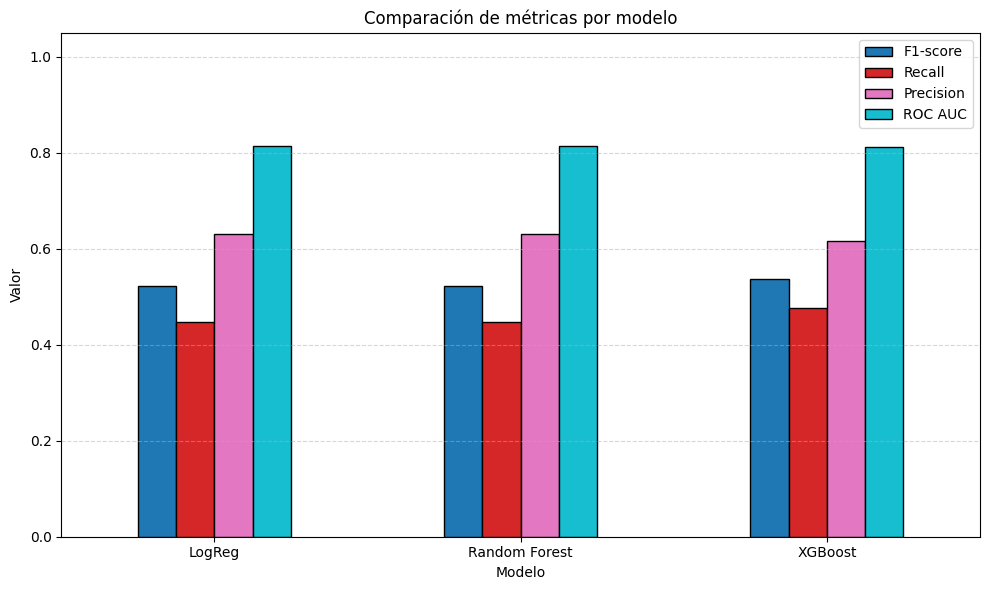

In [6]:
# Asegurate de tener estas variables definidas:
# y_val_pred, y_val_pred_rf, y_val_pred_xgb
# y_val_proba, y_val_proba_rf, y_val_proba_xgb

df_comparacion = evaluar_y_graficar_modelos(
    y_true=y_val,
    y_preds=[y_val_pred, y_val_pred_rf, y_val_pred_xgb],
    y_probas=[y_val_proba, y_val_proba_rf, y_val_proba_xgb],
    nombres=["LogReg", "Random Forest", "XGBoost"]
)

In [7]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def graficar_curvas_roc(y_true, y_probas, nombres):
    """
    Grafica curvas ROC de m√∫ltiples modelos.

    y_true: vector de etiquetas verdaderas
    y_probas: lista de probabilidades predichas (solo para clase positiva)
    nombres: lista de nombres de los modelos
    """
    plt.figure(figsize=(8, 6))

    for i in range(len(nombres)):
        fpr, tpr, _ = roc_curve(y_true, y_probas[i])
        plt.plot(fpr, tpr, label=f"{nombres[i]}")

    plt.plot([0, 1], [0, 1], "k--", label="Aleatorio")
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.title("Curvas ROC")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

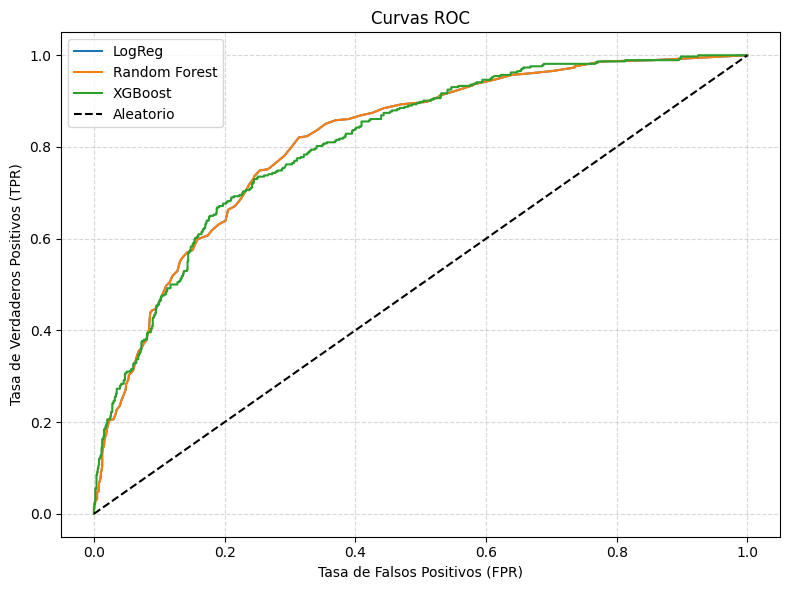

In [8]:
graficar_curvas_roc(
    y_true=y_val,
    y_probas=[y_val_proba, y_val_proba_rf, y_val_proba_xgb],
    nombres=["LogReg", "Random Forest", "XGBoost"]
)

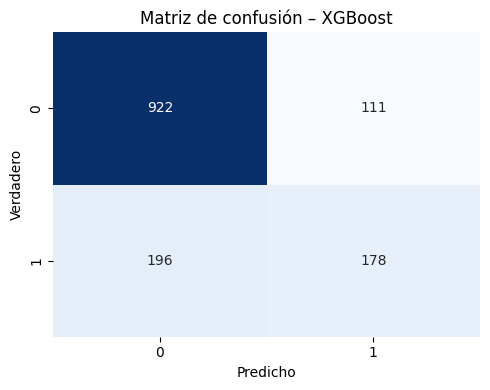

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_val_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de confusi√≥n ‚Äì XGBoost")
plt.tight_layout()
plt.show()

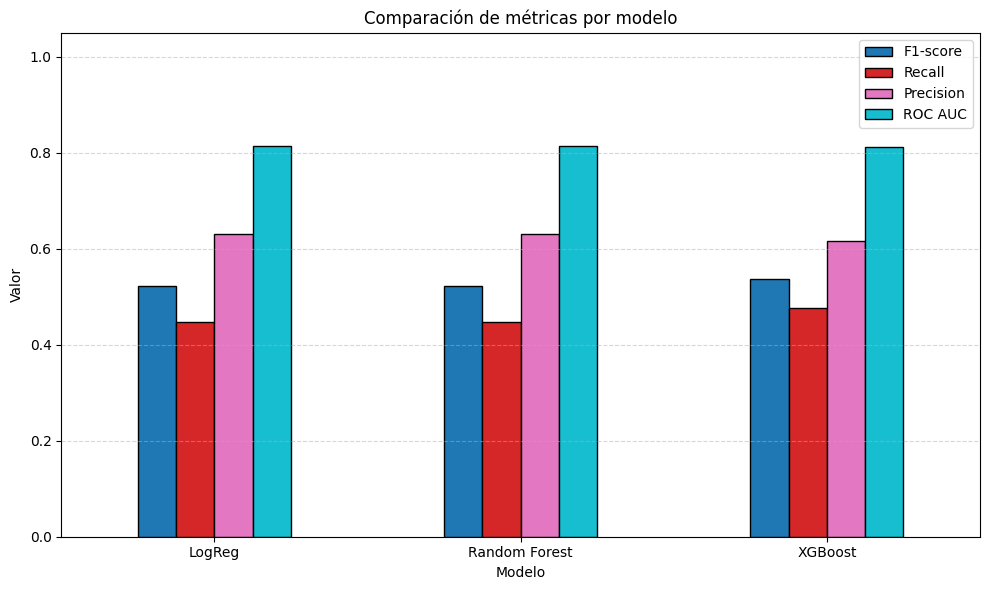

<Figure size 640x480 with 0 Axes>

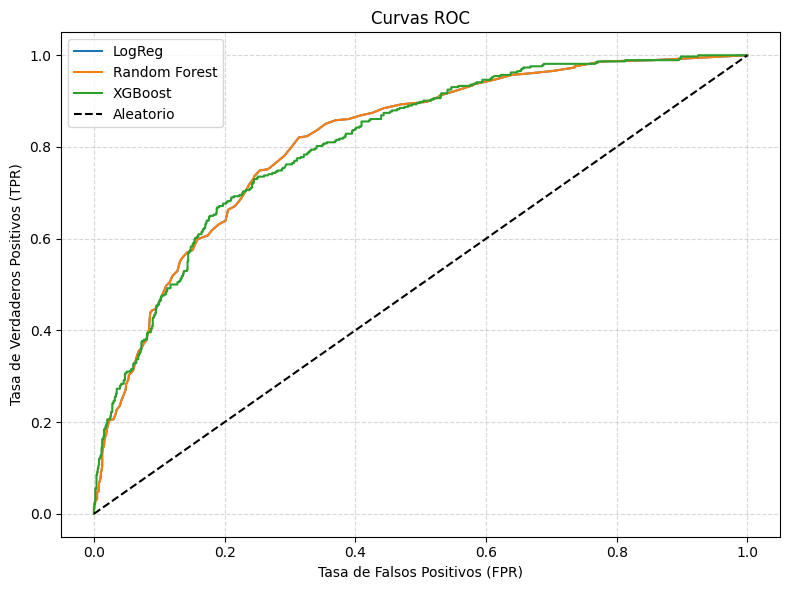

<Figure size 640x480 with 0 Axes>

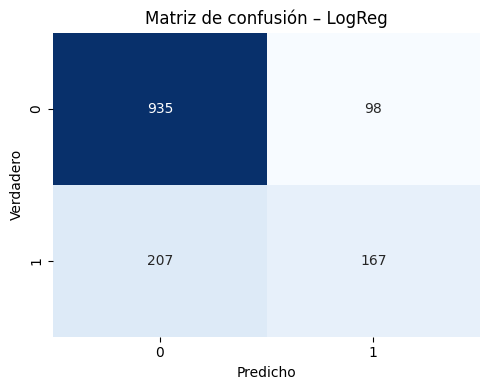

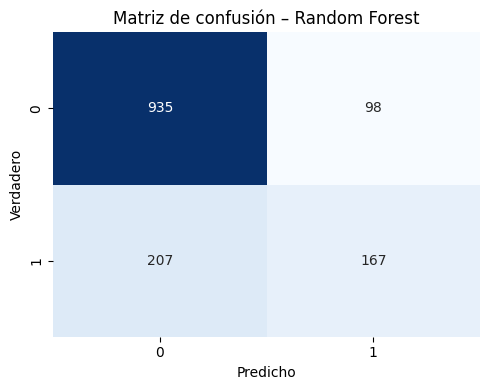

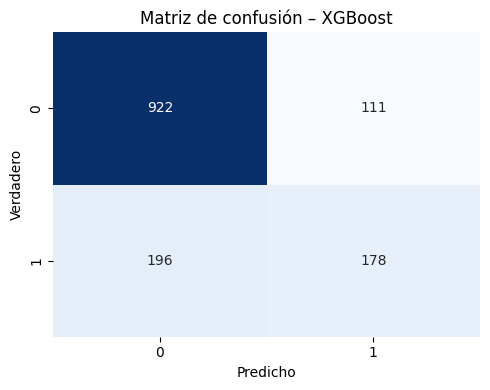

In [10]:
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ‚úÖ Asegurar carpeta de salida
os.makedirs("../outputs/plots", exist_ok=True)

# 1Ô∏è‚É£ Gr√°fico de barras comparativo de m√©tricas
df_comparacion = evaluar_y_graficar_modelos(
    y_true=y_val,
    y_preds=[y_val_pred, y_val_pred_rf, y_val_pred_xgb],
    y_probas=[y_val_proba, y_val_proba_rf, y_val_proba_xgb],
    nombres=["LogReg", "Random Forest", "XGBoost"]
)
plt.savefig("../outputs/plots/metrics_comparison.png")
plt.show()

# 2Ô∏è‚É£ Curva ROC
graficar_curvas_roc(
    y_true=y_val,
    y_probas=[y_val_proba, y_val_proba_rf, y_val_proba_xgb],
    nombres=["LogReg", "Random Forest", "XGBoost"]
)
plt.savefig("../outputs/plots/roc_curves.png")
plt.show()

# 3Ô∏è‚É£ Matrices de confusi√≥n (una por modelo)
modelos = ["LogReg", "Random Forest", "XGBoost"]
preds = [y_val_pred, y_val_pred_rf, y_val_pred_xgb]

for nombre, y_pred in zip(modelos, preds):
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicho")
    plt.ylabel("Verdadero")
    plt.title(f"Matriz de confusi√≥n ‚Äì {nombre}")
    plt.tight_layout()
    filename = f"../outputs/plots/confusion_matrix_{nombre.replace(' ', '_').lower()}.png"
    plt.savefig(filename)
    plt.show()

In [ ]:
## ‚úÖ Conclusi√≥n de la evaluaci√≥n

- Se compararon tres modelos de clasificaci√≥n entrenados previamente: Regresi√≥n Log√≠stica, Random Forest y XGBoost.
- Se calcularon m√©tricas clave (F1, Recall, Precision y AUC) sobre el set de validaci√≥n.
- Se visualizaron comparaciones gr√°ficas, curvas ROC y matrices de confusi√≥n.
- Todos los resultados se guardaron en `outputs/plots/` y las m√©tricas en `outputs/metrics/model_comparison.csv`.


In [11]:
# üì¶ Exportar resultados como CSV 
import os
os.makedirs("../outputs/metrics", exist_ok=True)
df_comparacion.to_csv("../outputs/metrics/model_comparison.csv", index=False)

# ‚úÖ Cierre del notebook
print("‚úÖ Evaluaci√≥n final completa.")
print("- Se evaluaron 3 modelos entrenados: LogReg, Random Forest y XGBoost.")
print("- Se calcularon F1, Recall, Precision y AUC.")
print("- Se graficaron las curvas ROC y las matrices de confusi√≥n.")
print("- Todos los gr√°ficos se guardaron en la carpeta outputs/plots/.")
print("- Las m√©tricas se exportaron a outputs/metrics/model_comparison.csv.")



‚úÖ Evaluaci√≥n final completa.
- Se evaluaron 3 modelos entrenados: LogReg, Random Forest y XGBoost.
- Se calcularon F1, Recall, Precision y AUC.
- Se graficaron las curvas ROC y las matrices de confusi√≥n.
- Todos los gr√°ficos se guardaron en la carpeta outputs/plots/.
- Las m√©tricas se exportaron a outputs/metrics/model_comparison.csv.


In [12]:
# üîÆ Predicciones sobre test y guardado en CSV para todos los modelos
X_test_pre = preprocessor.transform(X_test)

# Cargar customerID original (porque se pierde al dividir)
df_full = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df_full = df_full.dropna(subset=['TotalCharges'])  # mismo filtrado que en preprocessing
customer_ids = df_full.loc[X_test.index, "customerID"].values

# Predecir con cada modelo
y_test_pred_logreg = logreg.predict(X_test_pre)
y_test_proba_logreg = logreg.predict_proba(X_test_pre)[:, 1]

y_test_pred_rf = rf.predict(X_test_pre)
y_test_proba_rf = rf.predict_proba(X_test_pre)[:, 1]

y_test_pred_xgb = xgb.predict(X_test_pre)
y_test_proba_xgb = xgb.predict_proba(X_test_pre)[:, 1]

# Crear DataFrame combinado
df_preds_all = pd.DataFrame({
    "customerID": customer_ids,
    "LogReg_Pred": y_test_pred_logreg,
    "LogReg_Proba": y_test_proba_logreg,
    "RF_Pred": y_test_pred_rf,
    "RF_Proba": y_test_proba_rf,
    "XGB_Pred": y_test_pred_xgb,
    "XGB_Proba": y_test_proba_xgb
})

# Guardar a CSV
os.makedirs("../outputs/predictions", exist_ok=True)
df_preds_all.to_csv("../outputs/predictions/test_preds_all_models.csv", index=False)

print("‚úÖ Predicciones de test guardadas en: outputs/predictions/test_preds_all_models.csv")

‚úÖ Predicciones de test guardadas en: outputs/predictions/test_preds_all_models.csv
